In [1]:
import os
import re
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.stattools import adfuller

In [2]:
def adf_test(series, name="", alpha=0.05):
    """
    Kiểm tra tính dừng bằng Augmented Dickey-Fuller Test.
    In ra p-value và kết luận (Stationary / Non-stationary)
    """
    result = adfuller(series.dropna(), autolag="AIC")
    p_value = result[1]
    print(f"ADF Test [{name}]: p-value={p_value:.4f} -> "
          f"{'Stationary ✅' if p_value < alpha else 'Non-Stationary ❌'}")
    return p_value < alpha

In [3]:
def clean_numeric_series(s):
    """Làm sạch cột số: bỏ dấu %, dấu phẩy, khoảng trắng."""
    return pd.to_numeric(s.astype(str).str.replace('[,%]', '', regex=True).str.strip(), errors='coerce')

In [4]:
def parse_volume_field(v):
    """Chuyển đổi volume dạng 20.5M -> số"""
    if pd.isna(v):
        return np.nan
    v = str(v).replace(',', '').strip().upper()
    mult = 1
    if v.endswith('M'):
        mult = 1_000_000
        v = v[:-1]
    elif v.endswith('K'):
        mult = 1_000
        v = v[:-1]
    try:
        return float(v) * mult
    except:
        return np.nan

In [5]:
def normalize_df_autodetect(df):
    """Chuẩn hóa cột, rename Open/High/Low/Close/Volume tự động"""
    df = df.copy()
    # xác định cột date
    date_col = None
    for c in df.columns:
        try:
            pd.to_datetime(df[c].iloc[0], dayfirst=True)
            date_col = c
            break
        except:
            continue
    if date_col is None:
        date_col = df.columns[0]
    df = df.rename(columns={date_col: "date"})
    df['date'] = pd.to_datetime(df['date'], dayfirst=True, errors='coerce')
    df = df.dropna(subset=['date']).set_index('date').sort_index()

    # chuẩn hóa tên cột
    colmap = {}
    for c in df.columns:
        lc = c.lower()
        if any(x in lc for x in ["open", "mở", "mo"]):
            colmap[c] = "Open"
        elif any(x in lc for x in ["high", "cao"]):
            colmap[c] = "High"
        elif any(x in lc for x in ["low", "thấp", "thap"]):
            colmap[c] = "Low"
        elif any(x in lc for x in ["close", "lần cuối", "lần_cuối", "lan cuoi", "lầncuối", "lần", "close*"]):
            colmap[c] = "Close"
        elif any(x in lc for x in ["adj close", "adj_close", "điều chỉnh", "gia dieu chinh"]):
            colmap[c] = "Close"
        elif any(x in lc for x in ["volume", "kl", "số lượng", "vol"]):
            colmap[c] = "Volume"
    df = df.rename(columns=colmap)

    for c in ["Open","High","Low","Close"]:
        if c in df.columns:
            df[c] = clean_numeric_series(df[c])
    if "Volume" in df.columns:
        df["Volume"] = df["Volume"].apply(parse_volume_field)
    return df

In [6]:
def clean_and_merge(dfs: dict):
    """Gộp nhiều series lại thành 1 DataFrame theo index chung"""
    out = pd.DataFrame()
    for name, series in dfs.items():
        out[name] = series
    return out.sort_index()

In [7]:
def monthly_to_daily(df_monthly, date_col=None, value_col=None, start=None, end=None):
    """Chuyển dữ liệu theo tháng sang business-day series"""
    df = df_monthly.copy()
    if date_col is None:
        date_col = df.columns[0]
    if value_col is None:
        value_col = [c for c in df.columns if c != date_col][0]
    df[date_col] = pd.to_datetime(df[date_col], dayfirst=True, errors="coerce")
    df = df.dropna(subset=[date_col]).set_index(date_col).sort_index()
    series = clean_numeric_series(df[value_col])
    start = start or series.index.min()
    end   = end or series.index.max()
    full_idx = pd.date_range(start=start, end=end, freq="B")
    return series.reindex(full_idx).ffill().to_frame(name=value_col)

In [8]:
def build_exog_lagged(exog_df, q_map):
    """Tạo ma trận exog có các lag 0..q cho từng biến"""
    out = pd.DataFrame(index=exog_df.index)
    for exname, q in q_map.items():
        for l in range(0, q+1):
            out[f"{exname}_lag{l}"] = exog_df[exname].shift(l)
    return out

In [9]:
def reconstruct_prices(last_row, logret_df):
    """
    Từ log-return khôi phục lại giá thực tế dự báo (OHLC + Volume nếu có)
    """
    prices = pd.DataFrame(index=logret_df.index)

    for col in logret_df.columns:
        # Xử lý OHLC
        if col.endswith("_logret") and not col.startswith("Volume"):
            base_col = col.replace("_logret", "")
            if base_col not in last_row:
                continue  # bỏ qua nếu không có giá gốc
            base = np.log(last_row[base_col])
            prices[base_col] = np.exp(base + logret_df[col].cumsum())

        # Xử lý Volume_log (nếu có)
        elif col == "Volume_log" and "Volume" in last_row:
            base_vol = np.log(last_row["Volume"] + 1)
            prices["Volume"] = np.exp(base_vol + logret_df["Volume_log"].cumsum()) - 1

    return prices


In [10]:
def run_pipeline_dual(TSLA_csv, sp500_csv, spy_csv, us10y_csv, fedfunds_csv=None,
                      out_dataset="./TSLA_dataset.csv",
                      out_var_model="./TSLA_VAR.pkl",
                      out_varx_model="./TSLA_VARX.pkl",
                      max_var_lag=15, max_q=5, forecast_steps=5):
    print("=== [1] Load & Clean Data ===")
    TSLA = normalize_df_autodetect(pd.read_csv(TSLA_csv, dtype=str))
    sp500 = normalize_df_autodetect(pd.read_csv(sp500_csv, dtype=str))
    spy   = normalize_df_autodetect(pd.read_csv(spy_csv, dtype=str))
    us10y = normalize_df_autodetect(pd.read_csv(us10y_csv, dtype=str))
    fedfunds_df = pd.read_csv(fedfunds_csv, dtype=str) if fedfunds_csv else None

    aligned = clean_and_merge({
        "Open": TSLA.get("Open"),
        "High": TSLA.get("High"),
        "Low": TSLA.get("Low"),
        "Close": TSLA.get("Close"),
        "Volume": TSLA.get("Volume"),
        "SP500_Close": sp500.get("Close"),
        "SPY_Close": spy.get("Close"),
        "US10Y_Close": us10y.get("Close")
    })
    aligned = aligned.loc[aligned.index >= "2020-01-01"]
    aligned = aligned.loc[:pd.Timestamp(datetime.today().date())]
    for c in ["Open","High","Low","Close","SP500_Close","SPY_Close","US10Y_Close"]:
        if c in aligned: aligned[c] = aligned[c].ffill().bfill()
    aligned["Volume"] = aligned["Volume"].fillna(0)
    if fedfunds_df is not None:
        fed_daily = monthly_to_daily(fedfunds_df, start=aligned.index.min(), end=aligned.index.max())
        aligned["FEDFUNDS"] = fed_daily.iloc[:, 0].reindex(aligned.index).ffill().bfill()
    aligned = aligned.interpolate()
    print(f"Aligned range: {aligned.index.min().date()} → {aligned.index.max().date()} (n={len(aligned)})")

        # [2] Endogenous + Exogenous
    endo = pd.DataFrame(index=aligned.index)
    logret_cols = []
    for col in ["Open","High","Low","Close"]:
        if col in aligned:
            name = f"{col}_logret"
            endo[name] = np.log(aligned[col]).diff()
            logret_cols.append(name)
            adf_test(endo[name], name)  # kiểm tra tính dừng ngay sau khi tạo

    if "Volume" in aligned and not aligned["Volume"].isna().all():
        endo["Volume_log"] = np.log(aligned["Volume"] + 1)
    else:
        print("⚠️ Volume column missing or empty → skip Volume_log")

    # Drop các hàng NaN theo logret_cols để giữ đúng index
    endo = endo.dropna(subset=logret_cols)

    # --- Exogenous ---
    exog = pd.DataFrame(index=aligned.index)
    exog["SP500_logret"] = np.log(aligned["SP500_Close"]).diff()
    exog["SPY_logret"]   = np.log(aligned["SPY_Close"]).diff()
    exog["us10y_logret"] = np.log(aligned["US10Y_Close"]).diff()
    if "FEDFUNDS" in aligned:
        exog["fedfunds_logret"] = np.log(aligned["FEDFUNDS"]).diff()

    # Kiểm tra tính dừng cho từng biến ngoại sinh
    for col in exog.columns:
        adf_test(exog[col], name=col)

    data = pd.concat([endo, exog], axis=1).dropna()
    # ✅ Đảm bảo chỉ lấy các cột tồn tại
    endo = data[[c for c in endo.columns if c in data.columns]]
    exog = data[[c for c in exog.columns if c in data.columns]]

    # Đảm bảo index là DatetimeIndex
    data.index = pd.to_datetime(data.index)

    print(f"[DEBUG] data.index dtype: {data.index.dtype}, first date = {data.index.min()}")

    # Xuất CSV với cột Date
    data.to_csv(out_dataset, index_label="Date")

    # [3] Train/Test split
    split_idx = int(len(endo)*0.8)
    Y_train, Y_test = endo.iloc[:split_idx], endo.iloc[split_idx:]
    X_train, X_test = exog.iloc[:split_idx], exog.iloc[split_idx:]

    Y_train.index = pd.to_datetime(Y_train.index)
    Y_test.index  = pd.to_datetime(Y_test.index)
    X_train.index = pd.to_datetime(X_train.index)
    X_test.index  = pd.to_datetime(X_test.index)

    # [4] Chọn p
    sel = VAR(Y_train).select_order(max_var_lag)
    chosen_p = sel.aic
    print(f"\n=== Selected p (AIC) = {chosen_p} ===")

    # [5] Chọn q cho từng biến ngoại sinh
    print("\n=== Selecting q for each exogenous variable ===")
    chosen_q = {}
    for ex_col in X_train.columns:
        best_lag, best_score = 0, -np.inf
        for l in range(0, max_q+1):
            tmp = pd.concat([Y_train["Close_logret"], X_train[ex_col].shift(l)], axis=1).dropna()
            if len(tmp) < 30: continue
            score = abs(tmp.iloc[:,0].corr(tmp.iloc[:,1]))
            if score > best_score:
                best_score, best_lag = score, l
        chosen_q[ex_col] = best_lag
        print(f"  {ex_col}: chosen q = {best_lag} (|corr|={best_score:.4f})")

    # Build lagged exogenous
    X_train_lagged = build_exog_lagged(X_train, chosen_q).dropna()
    Y_train = Y_train.loc[X_train_lagged.index]
    X_test_lagged = build_exog_lagged(X_test, chosen_q).dropna()
    Y_test = Y_test.loc[X_test_lagged.index]

    # [6] Train VAR 
    var_model = VAR(Y_train).fit(maxlags=chosen_p)
    with open(out_var_model, "wb") as f:
        pickle.dump(var_model, f)
    # [7] Train VARX
    varx_model = VARMAX(Y_train, exog=X_train_lagged, order=(chosen_p, 0)).fit(disp=False)
    with open(out_varx_model, "wb") as f:
        pickle.dump(varx_model, f)

    # [8] Đánh giá
    results = {}
    var_forecast = var_model.forecast(Y_train.values, steps=len(Y_test))
    var_pred = pd.DataFrame(var_forecast, index=Y_test.index, columns=Y_test.columns)
    varx_pred = varx_model.get_forecast(steps=len(Y_test), exog=X_test_lagged).predicted_mean

    for model_name, pred in [("VAR", var_pred), ("VARX", varx_pred)]:
        metrics = {}
        for col in Y_test.columns:
            mse = mean_squared_error(Y_test[col], pred[col])
            mae = mean_absolute_error(Y_test[col], pred[col])
            rmse = np.sqrt(mse)
            cv = rmse / (np.std(Y_test[col]) + 1e-9)
            metrics[col] = {"MSE": mse, "MAE": mae, "RMSE": rmse, "CV(RMSE)": cv}
        results[model_name] = pd.DataFrame(metrics).T

    # [9] Forecast tương lai
    future_dates = pd.date_range(start=endo.index[-1] + pd.offsets.BDay(1),
                                 periods=forecast_steps, freq="B")
    var_future = var_model.forecast(Y_train.values, steps=forecast_steps)
    var_future_df = pd.DataFrame(var_future, index=future_dates, columns=Y_train.columns)
    varx_future = varx_model.get_forecast(
        steps=forecast_steps,
        exog=pd.DataFrame(0, index=future_dates, columns=X_train_lagged.columns)
    ).predicted_mean

    varx_future.index = future_dates


    # ✅ Tái dựng giá từ log-return dự báo
    last_prices = aligned[["Open","High","Low","Close"]].iloc[-1]
    var_future_prices = reconstruct_prices(last_prices, var_future_df)
    varx_future_prices = reconstruct_prices(last_prices, varx_future)

    print("\n=== Dự báo giá thực tế (VAR) ===")
    print(var_future_prices[["Open","High","Low","Close"]])

    print("\n=== Dự báo giá thực tế (VARX) ===")
    print(varx_future_prices[["Open","High","Low","Close"]])
    
    # Plot so sánh
    plt.figure(figsize=(12, 5))
    plt.plot(aligned.index[-100:], aligned["Close"].iloc[-100:], label="Hist Close", color="blue")
    plt.plot(var_future_prices.index, var_future_prices["Close"], 'o-', label="VAR Forecast", color="orange")
    plt.plot(varx_future_prices.index, varx_future_prices["Close"], 's-', label="VARX Forecast", color="green")
    plt.title("Close Price Forecast (VAR vs VARX)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    return var_model, varx_model, results, var_future_df, varx_future


=== [1] Load & Clean Data ===
Aligned range: 2020-01-02 → 2025-09-04 (n=1426)
ADF Test [Open_logret]: p-value=0.0000 -> Stationary ✅
ADF Test [High_logret]: p-value=0.0000 -> Stationary ✅
ADF Test [Low_logret]: p-value=0.0000 -> Stationary ✅
ADF Test [Close_logret]: p-value=0.0000 -> Stationary ✅
ADF Test [SP500_logret]: p-value=0.0000 -> Stationary ✅
ADF Test [SPY_logret]: p-value=0.0000 -> Stationary ✅
ADF Test [us10y_logret]: p-value=0.0000 -> Stationary ✅
ADF Test [fedfunds_logret]: p-value=0.0000 -> Stationary ✅
[DEBUG] data.index dtype: datetime64[ns], first date = 2020-01-03 00:00:00


c:\Users\aassd\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\aassd\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\aassd\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



=== Selected p (AIC) = 9 ===

=== Selecting q for each exogenous variable ===
  SP500_logret: chosen q = 0 (|corr|=0.5075)
  SPY_logret: chosen q = 0 (|corr|=0.1193)
  us10y_logret: chosen q = 0 (|corr|=0.1090)
  fedfunds_logret: chosen q = 2 (|corr|=0.0575)


c:\Users\aassd\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\aassd\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\aassd\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\aassd\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, cal


=== Dự báo giá thực tế (VAR) ===
                  Open        High         Low       Close
2025-09-05  336.999977  344.412520  340.935449  336.577614
2025-09-08  343.786120  354.373486  347.239958  346.833526
2025-09-09  350.358895  356.383660  347.159971  341.758323
2025-09-10  341.776794  352.489304  343.536588  342.385508
2025-09-11  350.878970  361.308836  348.876687  348.763112

=== Dự báo giá thực tế (VARX) ===
                  Open        High         Low       Close
2025-09-05  328.372624  336.528285  332.415233  329.643150
2025-09-08  337.565850  347.828590  340.801465  340.361482
2025-09-09  343.007468  348.528579  339.205300  332.791489
2025-09-10  333.667066  343.119350  333.856003  333.719993
2025-09-11  341.884478  352.124789  340.522877  340.394149


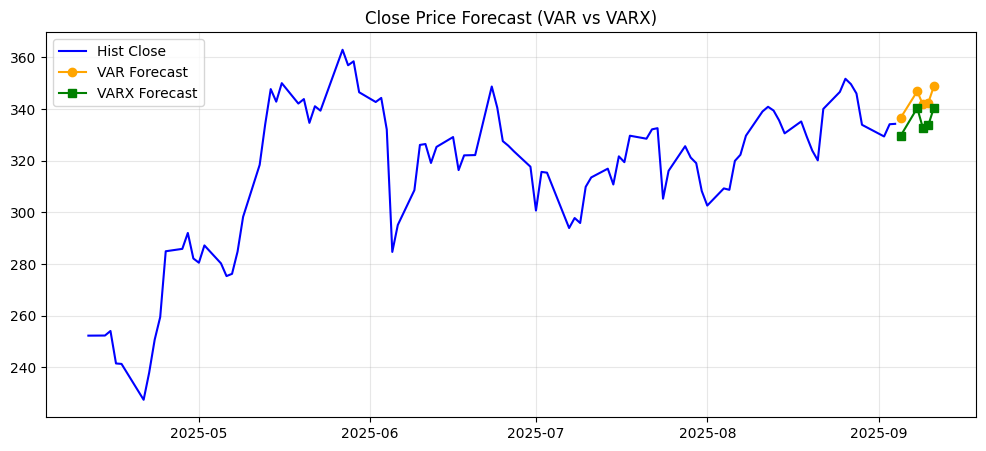


=== Evaluation Metrics (VAR) ===
                   MSE       MAE      RMSE  CV(RMSE)
Open_logret   0.001934  0.032010  0.043974  0.997523
High_logret   0.001340  0.027033  0.036600  0.998041
Low_logret    0.001568  0.028922  0.039598  0.999301
Close_logret  0.001922  0.031842  0.043842  0.997481
Volume_log    0.177245  0.349675  0.421005  1.211320

=== Evaluation Metrics (VARX) ===
                   MSE       MAE      RMSE  CV(RMSE)
Open_logret   0.002571  0.037555  0.050702  1.150136
High_logret   0.002966  0.038085  0.054465  1.485191
Low_logret    0.002169  0.034500  0.046567  1.175176
Close_logret  0.001416  0.027351  0.037631  0.856154
Volume_log    0.156638  0.314457  0.395775  1.138729

Dự báo VAR đã lưu -> TSLA_VAR_forecast.csv
Dự báo VARX đã lưu -> TSLA_VARX_forecast.csv


In [11]:
if __name__ == "__main__":
    # === CẤU HÌNH INPUT ===
    TSLA_csv = "TSLA.csv"
    sp500_csv = "SP500.csv"
    spy_csv   = "SPY.csv"
    us10y_csv = "US10Y.csv"
    fedfunds_csv = "FEDFUNDS.csv"

    # === CHẠY PIPELINE DUAL (VAR + VARX) ===
    var_model, varx_model, results, var_future_df, varx_future = run_pipeline_dual(
        TSLA_csv=TSLA_csv,
        sp500_csv=sp500_csv,
        spy_csv=spy_csv,
        us10y_csv=us10y_csv,
        fedfunds_csv=fedfunds_csv,
        out_dataset="./TSLA_dataset.csv",
        out_var_model="./TSLA_VAR.pkl",
        out_varx_model="./TSLA_VARX.pkl",
        max_var_lag=15,
        max_q=5,
        forecast_steps=5
    )

    # === IN KẾT QUẢ ===
    print("\n=== Evaluation Metrics (VAR) ===")
    print(results["VAR"])
    print("\n=== Evaluation Metrics (VARX) ===")
    print(results["VARX"])

    # === LƯU DỰ BÁO RA FILE CSV ===
    var_future_df.to_csv("./TSLA_VAR_forecast.csv")
    varx_future.to_csv("./TSLA_VARX_forecast.csv")

    print("\nDự báo VAR đã lưu -> TSLA_VAR_forecast.csv")
    print("Dự báo VARX đã lưu -> TSLA_VARX_forecast.csv")
